In [7]:
import sys
from clifford_inverse_search import gates_set, matrix_list, add_inverse_gates
from simple_simulation import simple_compiler, simple_processor, single_simple_simulation
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def simulation_test_run(num_gates_list, num_sample, add_FPGA_noise = True, t1 = None, t2 = None):
    fidelity_average = []
    fidelity_error = []
    for num_gates in num_gates_list:
        fidelity_list = [single_simple_simulation(
            num_gates, t1 = t1, t2 = t2, add_FPGA_noise = add_FPGA_noise
            ) for i in range(num_sample)]
        fidelity_average.append(np.mean(fidelity_list))
        fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    
    return fidelity_average, fidelity_error

In [9]:
# For num_sample = 20, takes about 5 min
num_sample = 5
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,20)

In [10]:
fidelity_baseline, error_baseline = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = None, t2 = None)
fidelity_FPGA, error_FPGA = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = None, t2 = None)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = 200, t2 = None)

Text(0, 0.5, 'Ground State Fidelity')

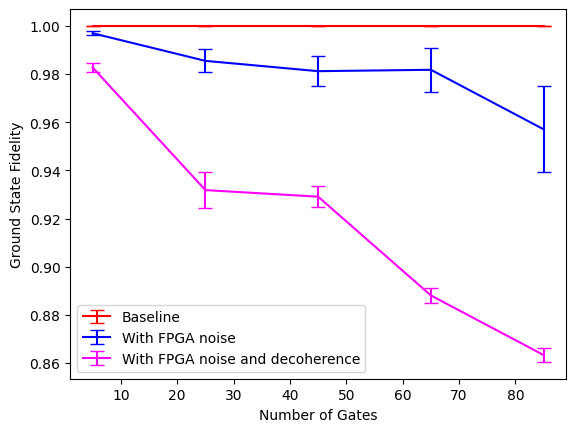

In [11]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='blue', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='magenta', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")